# linear models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

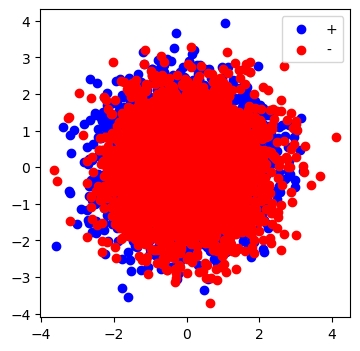

In [93]:
m,d = 8000,50
X = np.random.randn(m,d)
w = np.random.randn(X.shape[1])
y = (2*(X@w>0).astype(float)-1).reshape(X.shape[0],1)

Xpos= X[np.squeeze(y)==1]
Xneg = X[np.squeeze(y)==-1]

plt.figure(figsize=(4,4))
plt.scatter(Xpos[:,0],Xpos[:,1], color='blue', label='+')
plt.scatter(Xneg[:,0],Xneg[:,1], color='red', label='-')
plt.legend()

## LP for half space classification

General formulation of linear programming: $\min w\cdot c$ subject to 
\begin{align*}
A_{u} w &\le b_{u} \\
A_e w &= b_e \\
w_i &\in [a_i, b_i]
\end{align*}

run this to solve this LP
`result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)`

See https://docs.scipy.org/doc/scipy/tutorial/optimize.html#linear-programming-linprog

We can cast half space binary classfication as a LP problem. 
First, we want ERM solution which has zero empirical loss under the realisability assumption (here the loss function is the 0-1 loss $1_{y\neq h(x)}$ for a predictor $h$ and a training example $(x,y)$). Namely, we want that the prediction and the true label always matches  $y_i x_i w >0$ for all $i$. If this can be done, then we can also find a different $w$ such that  $ (x_i y_i) w \ge 1 $ for all training examples $(x_i, y_i)$. 
Second we have no objective to optimise, so we can simply set $c=0$.  
Writing all these in matrix form, we have a LP problem. 

In [99]:
c = np.zeros((X.shape[1],))
A_ub = -X*y
b_ub = -np.ones((X.shape[0],))
bounds = [(None,None)]*X.shape[1]

In [102]:
%timeit result = linprog(c,A_ub=A_ub,b_ub = b_ub, bounds = bounds)
# w, result.x
# print(f'similarity with the ground truth {result.x@w/ np.linalg.norm(result.x) / np.linalg.norm(w)}')

349 ms ± 9.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Perceptron for half spaces

Exercise: 
does it matter to 'tune' the learning rate? 

In [95]:
%%timeit
weights = np.random.randn(X.shape[1])
lr = 1
while True:
    ypred = 2*( X@weights >0 ) -1
    # print(f'accuracy {(ypred == np.squeeze(y)).mean()}')
    idx = np.where(ypred != np.squeeze(y))[0]
    if idx.size>0:
        weights += lr * (y[idx] * X[idx]).sum(axis=0)
    else: 
        # print('converged!')
        break

4.4 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
%%timeit
weights = np.random.randn(X.shape[1])
lr = 1
while True:
    ypred = 2*( X@weights >0 ) -1
    # print(f'accuracy {(ypred == np.squeeze(y)).mean()}')
    idx = np.where(ypred != np.squeeze(y))[0]
    if idx.size>0:
        i = np.random.choice(idx)
        weights += lr * np.squeeze(y)[i] * X[i]
    else: 
        # print('converged!')
        break

12.4 s ± 873 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
12.4e3 /4.4

2818.181818181818

## Least squares for linear regression

a regression problem is to find the relationship between $x\in \mathbb R^d$ and $y\in \mathbb R^p$. Linear regression assumes that the relationship is linear i.e.  $y = x \cdot w$ for some vector or matrix $w$. Sometimes we could add noise $y = x\cdot w + e$. Given data $((x_1,y_1),..., (x_n,y_n))$ and a metric on prediction quality such as least squares (aka mean squared error MSE):
$$
{1\over m}\sum_{i=1}^m  (y_i - x_i \cdot w)^2
$$
one can use calculus to find the optimal $w$ to minimise the metric. The solution is given by 
$$
w =  A^{-1}b  ~~~ \mbox{where} ~ A = X^T X, ~~~  b = X^T y
$$
where $X$ is $m\times d$ matrix ($m$ feature vectors stacked vertically), $y$ is $m$ dimensional column vector ($m$ predictions). When the feature dimension $d$ is high (e.g. $d\gg m$) then it is likely that $A$ is not invertible. However, the least square can stil be solved, using the Moore-Penrose (pseudo) inverse instead of the plain inverse which presumably does not exist. 

See this article for Moore-Penrose inverse: 
https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse

In [6]:
X = np.random.randn(80,3)
w = np.random.randn(X.shape[1])
y = X@w

In [7]:
A = X.T @ X
b = (X * y.reshape(X.shape[0],1)).sum(axis=0)

In [8]:
X.shape, y.shape, b.shape

((80, 3), (80,), (3,))

In [9]:
np.isclose(A**-1, np.linalg.inv(A))

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

In [10]:
wpred = np.linalg.inv(A) @ b

In [11]:
np.isclose(wpred,w)

array([ True,  True,  True])

## Logistic regression for classification (agnostic model)

the logistic regression assumes that data distribution takes the form $p_w(y|x) = \sigma( (x\cdot w) y )$ with $y\in \{+,-\}, x\in \mathbb R^d$ where $\sigma(z)=1/(1+e^{-z})$ is the sigmoid function. In particular, the label is random given the feature vector $x$, in contrary to the realisable/separable case where $y = f(x)$ for some deterministic $f: \mathbb R^d \to \{+,-\}$. 



In this probabilistic setting, a natural metric for assessing prediction quality is the likelihood. By monotonicity, maximsing the likelihood $p_w(y|x)$ is the same as minimizing the negative log likelihood $- \log p_w(y|x)$. Assuming iid data, then the quantity to minimize is 
$$
{1\over m}\sum_{i=1}^m  - \log p_w(y_i|x_i). 
$$
This metric is customarily called BCE loss 'binary cross entropy loss' for reason I am not explaining here. Computing the argmin of BCE gives the MLE. 

It is worth pointing out that logistic regression decision boundary is a hyperplane (the same as halfspace model mentioned earlier). Indeed, the prediction will be + if the output probability is larger than 0.5, which is the same as saying that $x\cdot w > 0$.  This is why LR is considered to be a linear model. This does NOT mean + data will be clearly separated from - data by a hyperplane. Near the decision boundary the probability is close to 0.5, so the labels are essentially determined by a coin flip, which could easily output a + label for a point in the - halfspace (close to decision boundary) 

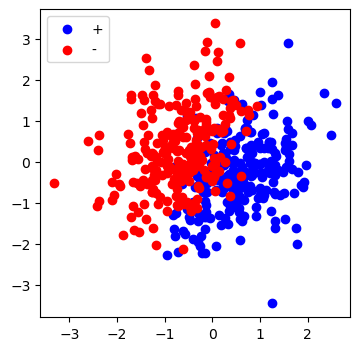

In [203]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def simi(w,w1):
    return w@w1/ (w@w)**0.5 / (w1@w1)**0.5

m = 500
d = 2
X = np.random.randn(m,d)
weights = np.random.randn(d) * 5
y = 2*(np.random.random(X.shape[0]) < sigmoid(X@weights)) - 1  # sample labels according to the ground truth probability
# (y==1).mean()

Xpos= X[y==1]
Xneg = X[y==-1]

plt.figure(figsize=(4,4))
plt.scatter(Xpos[:,0],Xpos[:,1], color='blue', label='+')
plt.scatter(Xneg[:,0],Xneg[:,1], color='red', label='-')
plt.legend()

In [205]:
w = np.random.randn(d)
p = sigmoid( (X@w)*y )
loss =  np.log(1 + np.exp(- (X@w) * y  )).mean()
print(loss)
print(-np.log(p).mean())
print(((2*(sigmoid(X@w)>0.5)-1)==y).mean())

1.038620708584513
1.038620708584513
0.338


In [206]:
lr = 0.001
for _ in range(10000):
    p = sigmoid( (X@w)*y )
    dw = ((p[:,np.newaxis] - 1) *  (X* y[:,np.newaxis])).mean(axis = 0)
    w += - lr * dw
    loss =  np.log(1 + np.exp(- (X@w) * y  )).mean()
print(loss)

0.37075858180473203


In [207]:
((2*(sigmoid(X@w)>0.5)-1)==y).mean()

0.876

In [202]:
weights,w, dw, simi(w,weights)

(array([ 0.22843168, -0.00140781]),
 array([-0.84393362, -0.25662504]),
 array([0.01430026, 0.00298468]),
 -0.9549335834220616)

# Learning theory: learnability 

learning problem: given iid data $S=\{(x_i,y_i), i\le m\}$, learn some $h$ in a hypothesis class $\cal H$ which generslises well for **unseen** data.

agnostic PAC learnable: for any $\varepsilon, \delta$ small, when $m$ is large, can find $h_S\in\cal H$ such that uniformly for all data distribution $D$
$$
\Pr[ L_D(h_S)< \inf_{h\in\cal H} L_D(h) + \varepsilon] > 1-\delta 
$$
where $L_D(h)= \mathbb E_{(x,y)\sim D}[\ell(h,(x,y))]$ is the true risk (aka generalisation error) of a hypothesis which depends on the choice of loss function $\ell$.

The minimal $m = m(\varepsilon, \delta)$ achieving this bound is called the sample complexity of the learning problem.  

## binary classification

Narual choice of loss is the 0-1 loss, in which case $L_D(h) = \Pr_{(x,y)\sim D}[ h(x)\ne y ]$. 
VC theory says that the following are equivalent whenever the loss function is bounded (e.g. 0-1 loss)

 - agnostic PAC learnable
 - ERM is a agnostic PAC learner
 - $\cal H$ has the uniform convergence property
 - $\cal H$ has finite VC dimension

Hence for learnable problems it suffices to compute ERM. 

For halfspace classification with 0-1 loss (VC dimension is finite so this is a learnable problem), computing ERM is easy in the realisable case (perceptron and LP are both polynomial time algorithm), NP hard in the non-realisable case.  

## multiclass learnability

Consider the 0-1 loss and k-way classification with $k\ge 3$. Then the following are equivalent: 

- agnostic PAC learnable
- $\cal H$ has finite Natarajan dimension

We don't mention ERM because ERM is not necessarily a PAC learner any more. 

## convex learning problems are PAC learnable

convex learning problem refers to the situation that the 
 - hypothesis class is convex bounded
 - the loss function is convex and Lipschitz

One can replace that second condtiion by 
 - the loss function is convex and smooth and non-negative. 

All convex problems can be learnt by RLM. 
SGD can be used to compute RLM in polynomial time. 
